# 💰 **Análise de Padrões de Consumo e Links na Machosfera**

## **Objetivo**
Este notebook tem como objetivo analisar a **dimensão comercial** dos vídeos coletados sobre comunidades *Red Pill* e *Machosfera*.

Muitos criadores de conteúdo utilizam discursos polêmicos como topo de funil para **venda de infoprodutos** (ebooks, cursos, mentorias) ou para redirecionar tráfego para outras redes sociais.

## **Etapas da Análise**
1.  **Extração de URLs:** Identificar todos os links presentes nas descrições e textos.
2.  **Categorização de Domínios:** Classificar os links em *Vendas* (Hotmart, Kiwify, etc.), *Redes Sociais* (Instagram, Telegram) e *Outros*.
3.  **Análise de Palavras-chave:** Quantificar termos que incentivam o consumo ("comprar", "desconto", "garanta", "manual").
4.  **Visualização:** Gráficos para evidenciar a proporção de conteúdo promocional.

# Imports

In [117]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Configuração de estilo dos gráficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Configuração do Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Bibliotecas importadas e Drive montado!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Bibliotecas importadas e Drive montado!


Carregamento dos Dados

In [118]:
# Caminho do arquivo (ajuste conforme seu ambiente, ex: Google Drive)
caminho_arquivo_2014_videos = '/content/drive/MyDrive/red_pill_analises/classificador/oficial_videos_classificacao/csvs_originais/videos_classificador_amanda.csv'

try:
    # Carregando o dataset
    # O parametro on_bad_lines='skip' ajuda caso o CSV tenha linhas mal formatadas
    df = pd.read_csv(caminho_arquivo_2014_videos, on_bad_lines='skip')

    print(f"Dataset carregado! Dimensões: {df.shape[0]} linhas e {df.shape[1]} colunas.")

except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado no caminho: {caminho_arquivo_2014_videos}")

Dataset carregado! Dimensões: 2015 linhas e 4 colunas.


In [119]:
columns_to_drop = ['apresenta misoginia (0/1)', 'apresenta toxicidade (0/1)']
df = df.drop(columns=columns_to_drop)

print(f"Colunas restantes: {df.columns.tolist()}")
display(df.head(3))

Colunas restantes: ['id_video_anonimizado', 'text']


,id_video_anonimizado,text
0,video_13528,Terminei meu namoro pq ela ficava curtindo FTs de homens de sunga #rafaelaires #antiotario #redpill
1,video_12459,"SOLTEIRA TENTANDO JUSTIFICAR SUA SOLIDÃO MAS SENHORES TODA MULHER SONHA EM SER MÃE E TER FAMILIA! seja bem vindo a mais um vídeo do canal, hoje vamos ver SOLTEIRA TENTANDO JUSTIFICAR SUA SOLIDÃO MAS SENHORES TODA MULHER SONHA EM SER MÃE E TER FAMILIA! Não se esqueça inscrever no CANAL e deixar o like além disso ative o sininho de notificações para não perder nenhum vídeo. vamos começar"
2,video_13145,"MULHER FALA QUE NÃO EXISTE HOMEM NO MUNDO #memes #humor #comedia #amelhorredpillvemdelas Olá! seja bem vindo a mais um video do canal, hoje vamos falar, sobre o porquê que o homem deve malhar e treinar. não se esqueça de se inscrever no canal e deixar o like além disso ative o sininho de notificações para não perder nenhum video. vamos começar;MULHER FALA QUE NÃO EXISTE HOMEM NO MUNDO"


## Funções de Extração e Categorização

Aqui definimos as regras de negócio para identificar o que é uma tentativa de venda ou promoção. Utilizamos **Expressões Regulares (Regex)** para capturar os links dentro dos textos não estruturados.

Pré-processamento com Regex

In [120]:
import re

def limpar_link_quebrado(texto):
    """
    Conserta links onde o usuário colocou espaços propositais para burlar filtros.
    Ex: 'www. youtube.com' vira 'www.youtube.com'
    Ex: 'https:// instagram.com' vira 'https://instagram.com'
    """
    if not isinstance(texto, str):
        return texto

    # 1. Remove espaço entre 'www.' e o domínio
    # Padrão: www. (espaço) texto
    texto_limpo = re.sub(r'(www\.)\s+', r'\1', texto)

    # 2. Remove espaço depois do protocolo http/https
    # Padrão: https:// (espaço) texto
    texto_limpo = re.sub(r'(https?://)\s+', r'\1', texto_limpo)

    # 3. (Opcional) Remove espaço antes de .com ou .br se for comum
    # Ex: youtube .com -> youtube.com
    texto_limpo = re.sub(r'\s+(\.(com|br|net|org))', r'\1', texto_limpo)

    return texto_limpo

In [121]:
import re

def extrair_urls(texto):
    """
    Extrai lista de URLs de um texto usando Regex, aplicando limpeza prévia.
    """
    if not isinstance(texto, str):
        return []

    # Função interna para limpar links quebrados (ex: 'www. youtube')
    def limpar_link_quebrado(t):
        t = re.sub(r'(www\.)\s+', r'\1', t)
        t = re.sub(r'(https?://)\s+', r'\1', t)
        return t

    # Limpar o texto antes de extrair
    texto_tratado = limpar_link_quebrado(texto)

    # Regex para capturar http, https e www
    url_pattern = r'(https?://\S+|www\.\S+)'
    urls = re.findall(url_pattern, texto_tratado)

    # Limpeza final: remover pontuação que possa ter vindo junto no final da URL
    urls = [url.rstrip('.,;:)') for url in urls]

    return urls

def categorizar_plataforma(url):
    """
    Classifica a URL com base em uma hierarquia de prioridades.
    PRIORIDADE: Redes Sociais > Mídia > Apostas > Vendas > Outros
    """
    url_lower = url.lower()

    # 1. REDES SOCIAIS E COMUNIDADE (Verifica PRIMEIRO para evitar falso positivo em perfil de criador)
    redes_sociais = [
        'instagram', 'tiktok', 'facebook', 't.me', 'telegram', 'whatsapp',
        'twitter', 'discord', 'kwai', 'linkedin', 'x.com', 'pinterest',
        'threads', 'wa.me', 'chat.whatsapp',
        # Agregadores (Linktree geralmente está na bio de rede social)
        'linktr.ee', 'urlgeni.us', 'abre.ai', 'bit.ly', 'substack'
    ]
    if any(k in url_lower for k in redes_sociais):
        return 'Redes Sociais/Comunidade'

    # 2. CONTEÚDO E MÍDIA (YouTube, Spotify, etc.)
    conteudo_midia = [
        'youtube', 'youtu.be', 'spotify', 'podcast', 'apple', 'googleusercontent',
        'canal', 'cortes', 'video', 'audio', 'live', 'redcast', 'shorts',
        'noticias', 'blog', 'site', 'artigo'
    ]
    if any(k in url_lower for k in conteudo_midia):
        return 'Conteúdo/Mídia'

    # 3. APOSTAS (Bets)
    apostas = [
        'bet', 'blaze', 'cassino', 'aposta', 'jogos', 'esportesdamasorte',
        'bet365', 'betano'
    ]
    if any(k in url_lower for k in apostas):
        return 'Apostas/Bet'

    # 4. VENDAS E INFOPRODUTOS (Só chega aqui se NÃO for rede social nem mídia)
    # Isso garante que 'alphalife.com' caia aqui, mas 'instagram.com/alphalife' caia em Redes Sociais
    vendas_infoprodutos = [
        # Plataformas Genéricas
        'hotmart', 'hotm.art', 'kiwify', 'edzz', 'eduzz', 'monetizze',
        'mpago', 'mercadopago', 'pag.ae', 'pagseguro', 'ticto', 'kirvano',
        'greenn', 'lastlink', 'privacy', 'braip', 'perfectpay',

        # Termos de Ação de Venda
        'loja', 'store', 'shop', 'comprar', 'checkout', 'payment', 'pay',
        'oferta', 'promo', 'cupom', 'pix', 'assinar', 'assinatura',

        # Criadores Específicos & Seus Produtos
        'rafaelaires', 'antiotario', 'manualantiotario', 'antiotariopro',
        'fabricioacunha', 'curso1.fabricioacunha',
        'matheuscopini', 'alphalife', 'alphalifeplus', 'copini', 'loveracademy',
        'thiagoschutz', 'elitemasculina', 'pinkepill', 'redpill',
        'karinefloriana', 'sedutorafro', 'topseduzir', 'marivabo',
        'redpillmasters', 'institutooliver', 'beway', 'educareal',
        'altoconselho',

        # Termos de Produtos/Iscas Digitais
        'metodo', 'metodoalpha', 'manual', 'guia', 'ebook', 'treinamento',
        'desafio', 'projeto', 'mentoria', 'privado', 'vip', 'clube',
        'antitrouxa', 'anti-trouxa', 'imperiodos', 'combo', 'pack',

        # Patrocinadores/Loja Física
        'amazon', 'amzn.to', 'mercadolivre', 'insiderstore', 'gsuplementos',
        'growth', 'ftw.com.br', 'dinoxx', 'manual.com.br', 'barbadeurso',

        # Apoio Financeiro
        'livepix', 'apoia.se', 'vakinha'
    ]
    if any(k in url_lower for k in vendas_infoprodutos):
        return 'Vendas/Infoprodutos'

    return 'Outros Sites'

# --- Execução ---
# 1. Aplica extração
df['lista_urls'] = df['text'].apply(extrair_urls)

# 2. Cria coluna binária (Tem/Não tem link)
df['tem_link'] = df['lista_urls'].apply(lambda x: 1 if len(x) > 0 else 0)

## Explosão dos Dados para Análise Detalhada

Como um texto pode ter múltiplos links (ex: um para o Instagram e outro para a Hotmart), vamos criar um DataFrame auxiliar onde **cada linha representa um link**. Isso facilita a contagem por categoria.

In [122]:
# "Explodir" a lista de URLs para que cada URL vire uma linha
df_links = df.explode('lista_urls')

# Remover linhas onde não havia links (NaN)
df_links = df_links.dropna(subset=['lista_urls'])

# Aplicar a categorização
df_links['categoria_link'] = df_links['lista_urls'].apply(categorizar_plataforma)

# Visualizar o resultado da classificação
display(df_links[['text', 'lista_urls', 'categoria_link']])

print(f"\nTotal de links encontrados: {len(df_links)}")

,text,lista_urls,categoria_link
7,não vim trazer a paz mas sim a espada #copiniresponde ► ALPHALIFE: https://alphalifeplus.com/► Capital Digital: https://alphalifeplus.com/pv-capital-digital-d/► Newsletter: Capital Society: https://capitalsociety.substack.com/subscribe#desenvolvimentopessoal #marketingdigital #masculinidadeMe encontre nas outras redes► Instagram https://www.instagram.com/copini_alphalife/► Tiktok https://www.tiktok.com/ ► Spotify https://open.spotify.com/show/4YHh4JPSMSJzcR8HxsIFfEContato:Suporte para alunos: alphalifesuporte .comEmail comercial: alphalifecopini .comWhatsapp comercial: 54 81228453,https://alphalifeplus.com/►,Vendas/Infoprodutos
7,não vim trazer a paz mas sim a espada #copiniresponde ► ALPHALIFE: https://alphalifeplus.com/► Capital Digital: https://alphalifeplus.com/pv-capital-digital-d/► Newsletter: Capital Society: https://capitalsociety.substack.com/subscribe#desenvolvimentopessoal #marketingdigital #masculinidadeMe encontre nas outras redes► Instagram https://www.instagram.com/copini_alphalife/► Tiktok https://www.tiktok.com/ ► Spotify https://open.spotify.com/show/4YHh4JPSMSJzcR8HxsIFfEContato:Suporte para alunos: alphalifesuporte .comEmail comercial: alphalifecopini .comWhatsapp comercial: 54 81228453,https://alphalifeplus.com/pv-capital-digital-d/►,Vendas/Infoprodutos
7,não vim trazer a paz mas sim a espada #copiniresponde ► ALPHALIFE: https://alphalifeplus.com/► Capital Digital: https://alphalifeplus.com/pv-capital-digital-d/► Newsletter: Capital Society: https://capitalsociety.substack.com/subscribe#desenvolvimentopessoal #marketingdigital #masculinidadeMe encontre nas outras redes► Instagram https://www.instagram.com/copini_alphalife/► Tiktok https://www.tiktok.com/ ► Spotify https://open.spotify.com/show/4YHh4JPSMSJzcR8HxsIFfEContato:Suporte para alunos: alphalifesuporte .comEmail comercial: alphalifecopini .comWhatsapp comercial: 54 81228453,https://capitalsociety.substack.com/subscribe#desenvolvimentopessoal,Redes Sociais/Comunidade
7,não vim trazer a paz mas sim a espada #copiniresponde ► ALPHALIFE: https://alphalifeplus.com/► Capital Digital: https://alphalifeplus.com/pv-capital-digital-d/► Newsletter: Capital Society: https://capitalsociety.substack.com/subscribe#desenvolvimentopessoal #marketingdigital #masculinidadeMe encontre nas outras redes► Instagram https://www.instagram.com/copini_alphalife/► Tiktok https://www.tiktok.com/ ► Spotify https://open.spotify.com/show/4YHh4JPSMSJzcR8HxsIFfEContato:Suporte para alunos: alphalifesuporte .comEmail comercial: alphalifecopini .comWhatsapp comercial: 54 81228453,https://www.instagram.com/copini_alphalife/►,Redes Sociais/Comunidade
7,não vim trazer a paz mas sim a espada #copiniresponde ► ALPHALIFE: https://alphalifeplus.com/► Capital Digital: https://alphalifeplus.com/pv-capital-digital-d/► Newsletter: Capital Society: https://capitalsociety.substack.com/subscribe#desenvolvimentopessoal #marketingdigital #masculinidadeMe encontre nas outras redes► Instagram https://www.instagram.com/copini_alphalife/► Tiktok https://www.tiktok.com/ ► Spotify https://open.spotify.com/show/4YHh4JPSMSJzcR8HxsIFfEContato:Suporte para alunos: alphalifesuporte .comEmail comercial: alphalifecopini .comWhatsapp comercial: 54 81228453,https://www.tiktok.com/,Redes Sociais/Comunidade
...,...,...,...
2010,"** ENTENDA ** Por Que a Gordura Facial Afeta Negativamente Sua Atratividade (Looksmaxxing Facial) Qual Sua Atratividade Facial De 1-10? Obtenha Sua Analise 🔍😊👤💡📏https://abre.ai/iX8DAdiquira o Ebook ""Guia De Looksmaxxing De 10 Etapas"" 👔✨📚📝👩‍🎨👨‍🎨📖https://abre.ai/iX8EAdiquira o Ebook "" Looksmaxxing De Maneira Errada"" GRATIS"" 👔✨📚📝👩‍🎨https://abre.ai/iX8HMe Siga No Instagram 👣👉📸😊https://urlgeni.us/instagram/N0KqWMe Siga No TikTok 👣👉🎵😊https://urlgeni.us/tiktok/xcIwWMe Siga No Face 👣👉📘😊https://urlgeni.us/facebook/HEnL",https://abre.ai/iX8EAdiquira,Redes Sociais/Comunidade
2010,"** ENTENDA ** Por Que a Gordura Facial Afeta Negativamente Sua Atratividade (Looksma


Total de links encontrados: 4654
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [123]:
df_outros_sites = df_links[df_links['categoria_link'] == 'Outros Sites']
print(f"Total de links na categoria 'Outros Sites': {len(df_outros_sites)}")

# Manter a largura máxima de coluna como None para que outras colunas não sejam truncadas
pd.set_option('display.max_colwidth', None)

# Criar uma cópia para exibição e truncar apenas a coluna 'text' nesta cópia
df_display = df_outros_sites.copy()
max_text_length = 200  # Definir o tamanho máximo desejado para a coluna 'text'
df_display['text'] = df_display['text'].apply(lambda x: x[:max_text_length] + '...' if len(str(x)) > max_text_length else x)

display(df_display)

Total de links na categoria 'Outros Sites': 225


,id_video_anonimizado,text,lista_urls,tem_link,categoria_link
24,video_4457,POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! Você já percebeu alguém que parece interessado em você começar a se afas...,https://chatgpt.com/imagens,1,Outros Sites
24,video_4457,POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! Você já percebeu alguém que parece interessado em você começar a se afas...,https://piclumen.com,1,Outros Sites
24,video_4457,POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! Você já percebeu alguém que parece interessado em você começar a se afas...,https://www.canva.com/imagens,1,Outros Sites
24,video_4457,POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! Você já percebeu alguém que parece interessado em você começar a se afas...,https://www.seaart.ai/ptEdição,1,Outros Sites
24,video_4457,POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! POR QUE ELE FOGE? O SINAL SURPREENDENTE DE QUE ESTÁ APAIXONADO! Você já percebeu alguém que parece interessado em você começar a se afas...,https://www.capcut.com/Voz,1,Outros Sites
...,...,...,...,...,...
1805,video_13551,MC ESTUDANTE DETONA EX NAMORADA 10/10 LCR 🎙️ Novo na transmissão ou querendo melhorar? Confira o StreamYard e ganhe $10 de desconto! 😍 https://streamyard.com/pal/d/5113770070114304,https://streamyard.com/pal/d/5113770070114304,1,Outros Sites
1876,video_10896,É ISSO QUE ACONTECE QUANDO A MULHER POSTA FOTO NA ACADEMIA | THIAGO SCHUTZ | PINK E PILL INSCREVA-SE NO CANAL DE CORTES (MELHORES MOMENTOS): https://www.youtube.com/ ASSISTA AO EPISÓDIO COMPLETO:htt...,http://www.lucyapp.com.br/pink---------------------EPISÓDIO,1,Outros Sites
1896,video_1904,"ESPECIAL LEI MARIA DA PENHA E DIREITO DO HOMEM: Part. Jamilly Wenceslau, Alexandre Correa e Júnior. ▶ Junior Masters veste Insider 👕 Ganhe 12% OFF em todo o site usando o cupom REDCAST12! #insiderstor...",www.estudiosmcm.com.br,1,Outros Sites
1925,video_4347,MAIS UMA PROVA DE QUE O CASAMENTO ATUAL É O MAIOR PERIGO PARA OS HOMENS! A REALIDADE É SOBERANA Quando começamos a desvendar o profano feminino e sistema pró-mulher e anti-homem e que era para os home...,https://www.mulher.com.br/comportamento/quanto-mais-parceiros-voce-tiver-enquanto-solteira-mais-infeliz-sera-no-casamento#relacionamento,1,Outros Sites


In [124]:
df_apostas_bet = df_links[df_links['categoria_link'] == 'Apostas/Bet']

print(f"Total de links na categoria 'Apostas/Bet': {len(df_apostas_bet)}")
display(df_apostas_bet[['text', 'lista_urls', 'categoria_link']])

Total de links na categoria 'Apostas/Bet': 0


,text,lista_urls,categoria_link


## Análise Visual: O que eles estão divulgando?

Vamos visualizar a distribuição dos tipos de links para confirmar a hipótese de que o conteúdo serve como funil para vendas ou outras redes.

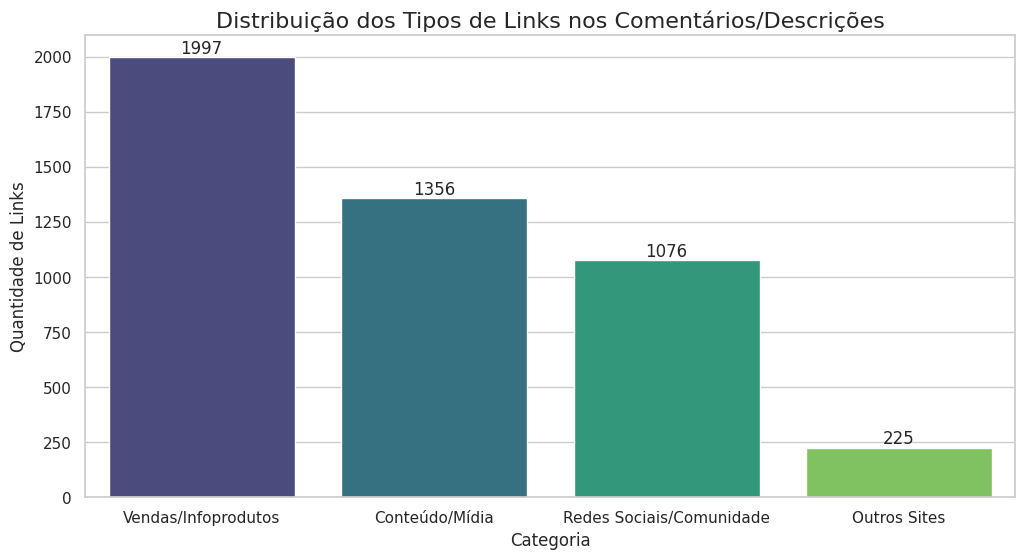


--- Legenda das Categorias de Links ---
• Vendas/Infoprodutos: Links para plataformas de venda (Hotmart, Kiwify), lojas online (Amazon, Insider), ou produtos específicos (ebooks, cursos, mentorias, 'Manual AntiOtário', 'AlphaLife').
• Conteúdo/Mídia: Links para consumo de mídia (YouTube, Spotify), notícias, blogs ou artigos.
• Redes Sociais/Comunidade: Links que direcionam para perfis ou grupos em redes sociais (Instagram, Telegram, TikTok, Linktree) ou plataformas de mensagens (WhatsApp).
• Outros Sites: Links que não se encaixam nas categorias acima, como sites institucionais, pesquisas ou links diversos.
• Apostas/Bet: Links para plataformas de apostas e jogos de azar (Blaze, Bet365).


In [125]:
# Contagem por Categoria
contagem_categorias = df_links['categoria_link'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=contagem_categorias.index, y=contagem_categorias.values, hue=contagem_categorias.index, palette="viridis", legend=False)

plt.title("Distribuição dos Tipos de Links nos Comentários/Descrições", fontsize=16)
plt.ylabel("Quantidade de Links", fontsize=12)
plt.xlabel("Categoria", fontsize=12)

# Adicionar valores nas barras
for i in barplot.containers:
    barplot.bar_label(i,)

plt.show()

# Adicionar legenda explicativa
print("\n--- Legenda das Categorias de Links ---")
print("• Vendas/Infoprodutos: Links para plataformas de venda (Hotmart, Kiwify), lojas online (Amazon, Insider), ou produtos específicos (ebooks, cursos, mentorias, 'Manual AntiOtário', 'AlphaLife').")
print("• Conteúdo/Mídia: Links para consumo de mídia (YouTube, Spotify), notícias, blogs ou artigos.")
print("• Redes Sociais/Comunidade: Links que direcionam para perfis ou grupos em redes sociais (Instagram, Telegram, TikTok, Linktree) ou plataformas de mensagens (WhatsApp).")
print("• Outros Sites: Links que não se encaixam nas categorias acima, como sites institucionais, pesquisas ou links diversos.")
print("• Apostas/Bet: Links para plataformas de apostas e jogos de azar (Blaze, Bet365).")

## Análise Semântica de Vendas (Gatilhos de Consumo)

Além dos links, analisamos a presença de termos que denotam **urgência** ou **comercialização** no texto, independentemente de haver um link clicável. Termos como "Garanta", "Vagas limitadas", "Manual", "Ebook".

In [126]:
# Lista de termos associados a vendas e consumo na "red pill"
termos_consumo = [
    # Foco em produto e ação
    'curso', 'ebook', 'mentoria', 'manual', 'metodo', 'fórmula', 'antiotário',
    'comprar', 'adquira', 'garanta',

    # Novos termos de Acesso/Ação
    'acesse', 'inscrição', 'entrada', 'código', 'pagamento', 'reembolso',
    'garantia', 'vagas', 'acesso',

    # Novos termos de Produto/Conteúdo
    'livro', 'grupo', 'privado', 'lições', 'aula', 'programa', 'sistema',
    'treinamento', 'masters', 'desenvolvimento',

    # Novos termos Promocionais/Status
    'desconto', 'cupom', 'oferta', 'bônus', 'grátis', 'exclusivo',
    'vip', 'premium', 'investimento', 'últimas'
]

def contar_termos_consumo(texto):
    if not isinstance(texto, str):
        return 0
    texto_lower = texto.lower()
    return sum(1 for termo in termos_consumo if termo in texto_lower)

# Aplicar contagem
df['qtd_termos_venda'] = df['text'].apply(contar_termos_consumo)

# Filtrar apenas os que possuem termos de venda para análise
df_vendas = df[df['qtd_termos_venda'] > 0].copy()

print(f"Vídeos/Textos com linguagem de venda identificada: {len(df_vendas)} de {len(df)}")

# Exibir exemplos de textos altamente comerciais
top_vendas = df_vendas.sort_values(by='qtd_termos_venda', ascending=False).head(3)
for index, row in top_vendas.iterrows():
    print(f"\n--- Texto (ID: {row.get('id_video_anonimizado', 'N/A')}) ---")
    print(row['text'][:300] + "...") # Exibe apenas os primeiros 300 caracteres

Vídeos/Textos com linguagem de venda identificada: 966 de 2015

--- Texto (ID: video_1831) ---
Não faz um agrado pro marido e no dia do pagamento quer unha de gel e cabelo feito. 🍷🗿 1- Adquira o AntiOtário clicando no site abaixo.👉🏻 https://hotm.art/ManualAnti 📕2- Domine as lições do nosso livro. 🍷3- Faça parte do nosso grupo privado. 🗿Te espero lá. 🫡AntiOtário, livro de desenvolvimento pesso...

--- Texto (ID: video_1998) ---
LIVE AO VIVO AV. PAULISTA 7 DE SETEMBRO: BOLSONARO, PABLO MARÇAL  🇧🇷 🇧🇷 Ⓜ️ E TODA DIREITA! ▶ BATISMO BITCOINhttps://payfast.greenn.com.br/redirect/113648/?a_id=913455.A SpikeToSpike é um ecossistema P2P, feito para conectar pessoas interessadas em negociar Bitcoin de maneira segura e com respeito à ...

--- Texto (ID: video_3397) ---
WAGNER THOMAZONI (TRAGICÔMICO) - REDCAST! ▶ BATISMO BITCOINhttps://payfast.greenn.com.br/redirect/113648/?a_id=913455.A SpikeToSpike é um ecossistema P2P, feito para conectar pessoas interessadas em negociar Bitcoin de maneira segura

## Análises Percentuais

## Preparação dos Dados para Visualização

Antes de gerar os gráficos, criamos um DataFrame auxiliar (`df_links`) onde cada linha representa um link único. Isso facilita a contagem e segmentação por categorias sem duplicar código nos blocos de plotagem.

In [127]:
# Configuração Global de Estilo
sns.set_theme(style="white", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)

# Definição da Paleta de Cores (Reutilizável)
CORES_CATEGORIAS = {
    'Vendas/Infoprodutos': '#e74c3c',      # Vermelho (Destaque)
    'Redes Sociais/Comunidade': '#3498db', # Azul
    'Conteúdo/Mídia': '#95a5a6',           # Cinza
    'Apostas/Bet': '#f1c40f',              # Amarelo
    'Outros Sites': '#bdc3c7'
}

### Gráfico 1: Saturação de Links (Funil de Conversão)

Este gráfico de rosca ilustra a agressividade da estratégia de direcionamento de tráfego. Ele responde à pergunta: **"Qual a proporção de conteúdos que tentam retirar o usuário da plataforma?"**

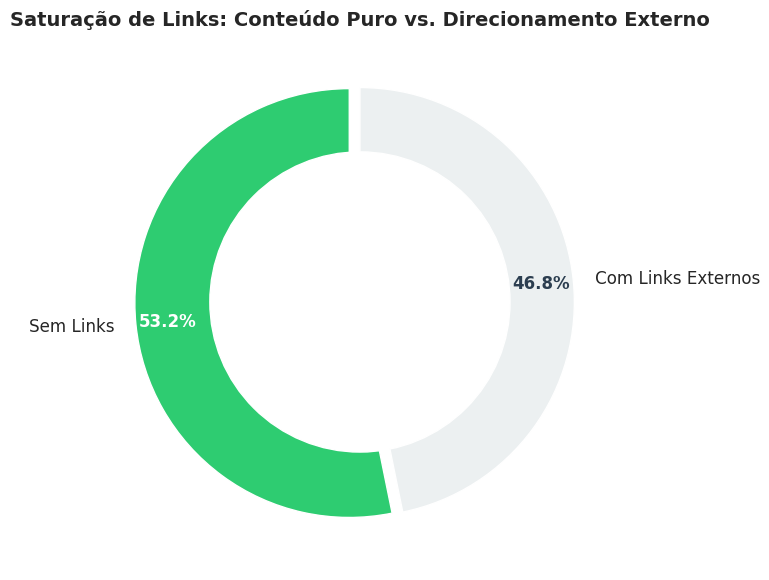

In [128]:
# Dados: Contagem de vídeos com vs. sem link
# Recalculando 'tem_link' caso não exista, baseado na lista original
contagem = df['lista_urls'].apply(lambda x: 'Com Links Externos' if len(x) > 0 else 'Sem Links').value_counts()

# Plotagem
fig, ax = plt.subplots(figsize=(10, 6))

wedges, texts, autotexts = ax.pie(
    contagem,
    labels=contagem.index,
    colors=['#2ecc71', '#ecf0f1'], # Verde e Cinza
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    explode=(0.05, 0)
)

# Estilização do texto percentual
plt.setp(autotexts, size=12, weight="bold", color="white")
plt.setp(autotexts[1], color="#2c3e50") # Ajuste de cor para o fundo claro

# Círculo central para transformar Pizza em Rosca
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Saturação de Links: Conteúdo Puro vs. Direcionamento Externo', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Gráfico 2: Penetração por Categoria

Este gráfico de barras evidencia quais estratégias predominam. Diferente de um gráfico de pizza, ele permite visualizar a **frequência relativa** de cada tipo de link sobre o total de vídeos que possuem links externos.

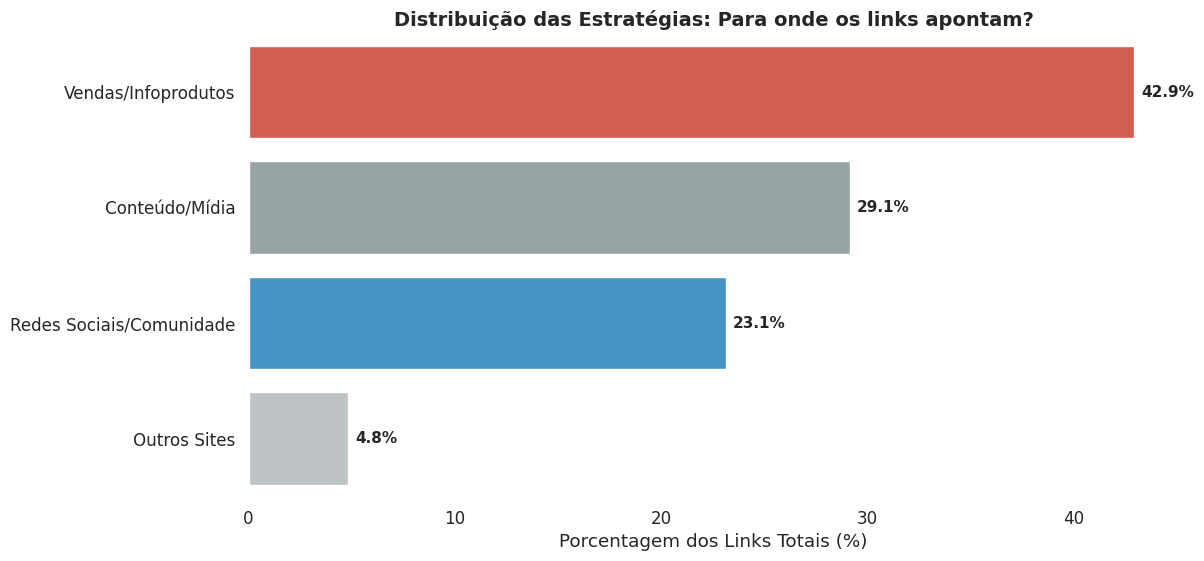

In [132]:
# Dados: Frequência de cada categoria
df_cat_counts = df_links['categoria_link'].value_counts(normalize=True) * 100
df_cat_counts = df_cat_counts.reset_index()
df_cat_counts.columns = ['Categoria', 'Porcentagem']

# Plotagem
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Porcentagem',
    y='Categoria',
    data=df_cat_counts,
    hue='Categoria', # Atribuindo a variável 'y' a 'hue' conforme a recomendação
    palette=CORES_CATEGORIAS, # Uso da paleta global
    legend=False # Ocultando a legenda pois as cores já estão associadas às categorias no eixo Y
)

# Adicionar rótulos de dados nas barras
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%', padding=5, fontweight='bold', fontsize=11)

plt.title('Distribuição das Estratégias: Para onde os links apontam?', fontsize=14, fontweight='bold')
plt.xlabel('Porcentagem dos Links Totais (%)')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

### Gráfico 3: Top Domínios de Venda (Share of Voice)

Focando especificamente na categoria **"Vendas/Infoprodutos"**, este gráfico revela quais plataformas ou produtos dominam o ecossistema comercial analisado.

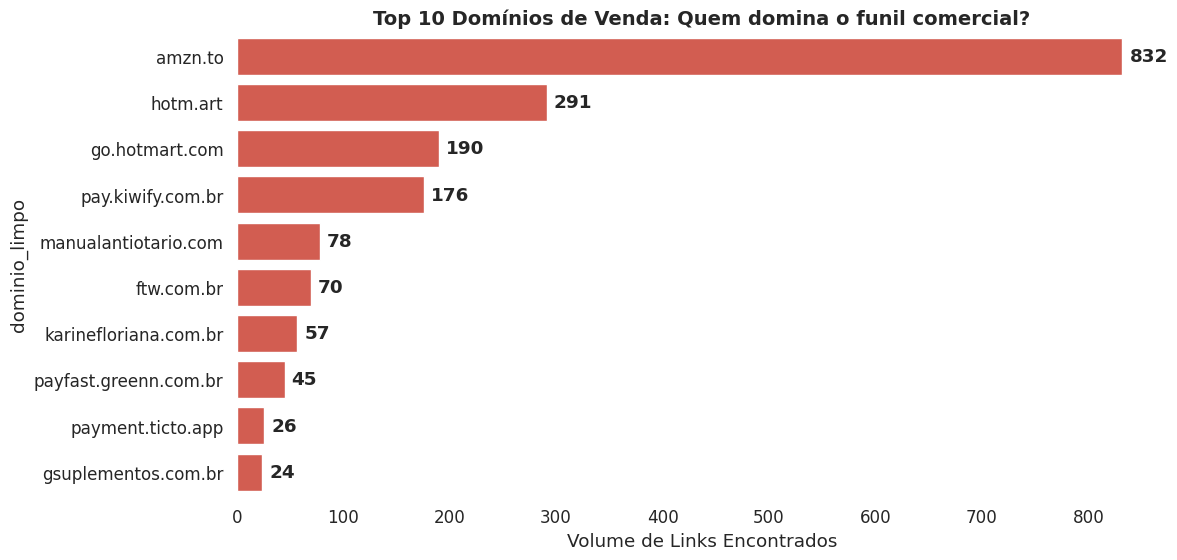

In [134]:
# Função auxiliar para limpar domínio (extrair apenas o nome principal)
def limpar_dominio(url):
    match = re.search(r'https?://(?:www\.)?([^/]+)', url)
    return match.group(1) if match else url

# Filtragem e Processamento
df_vendas = df_links[df_links['categoria_link'] == 'Vendas/Infoprodutos'].copy()
df_vendas['dominio_limpo'] = df_vendas['lista_urls'].apply(limpar_dominio)

# Top 10 domínios
top_dominios = df_vendas['dominio_limpo'].value_counts().head(10)

# Plotagem
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=top_dominios.values,
    y=top_dominios.index,
    color=CORES_CATEGORIAS['Vendas/Infoprodutos']
)

plt.title('Top 10 Domínios de Venda: Quem domina o funil comercial?', fontsize=14, fontweight='bold')
plt.xlabel('Volume de Links Encontrados')

# Rótulos
for i in ax.containers:
    ax.bar_label(i, padding=5, fontweight='bold')

sns.despine(left=True, bottom=True)
plt.show()